In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Dataset info

In [4]:
n_iterations=100
overlap_thr=None #0.5
n_processes=1
responsive_test='nstds'
experiment='blobs'
C_value=None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, '-o', overlap_thr, '-C', C_value]

opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Set responsivitiy params
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
responsive_thr = float(opts.responsive_thr) #10
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 

# Create data ID for labeling figures with data-types
stim_filterby = None #'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'
filter_str = 'filter_%s_%s' % (stim_filterby, g_str)
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
data_id = '|'.join([traceid, filter_str, response_str])
print(data_id)


# Choose what type classifier to make
m0=int(opts.class_a) #0
m100=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
overlap_thr = None if opts.overlap_thr is None else float(opts.overlap_thr) 


# Set classifier training params
C_value = opts.C_value
do_cv = C_value is None
C_value = None if do_cv else float(opts.C_value)
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))


traces001|filter_None_blobsonly|dff_nstds-thr-10.00
Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=None, C=None


In [5]:
train_str = 'by_singlecells_iter-%i' % (n_iterations)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Output dir

In [6]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', 'single_cells')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    print(dst_dir)

# Get metadata for experiment type

In [7]:
#### Get metadata for experiment type
sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)

sdata_exp = sdata[sdata['experiment']==experiment]
#sdata_exp['visual_area'].unique()

edata, expmeta = aggr.experiment_datakeys(sdata, experiment='blobs',
                                has_gratings=has_gratings, stim_filterby=stim_filterby)
print(edata['visual_area'].unique())

Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
[u'Li' u'Ll' u'Lm' u'V1']


In [8]:
 # Get blob metadata only - and only if have RFs
if overlap_thr is not None:
    dsets = pd.concat([g for k, g in edata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
else:
    dsets = pd.concat([g for k, g in edata.groupby(['animalid', 'session', 'fov']) if 
                        experiment in g['experiment'].values])
dsets[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,18
Ll,3
Lm,16
V1,16


In [9]:
# #### Check stimulus configs
# stim_datakeys = dsets['datakey'].unique()
# SDF, renamed_configs = aggr.check_sdfs(stim_datakeys, traceid=traceid, 
#                                        images_only=False, return_incorrect=True)

In [10]:
#### Load neural responses
trial_epoch= 'plushalf' #'stimulus'
responsive_test='nstds' #'roc'
responsive_thr=10 #10 #0.05
response_type='dff'

#### Check for equal trial counts
_, cells, MEANS, SDF = aggr.get_source_data(experiment, equalize_now=True, 
                                       response_type=response_type,
                                       responsive_test=responsive_test, 
                                       responsive_thr=responsive_thr, 
                                       trial_epoch=trial_epoch, check_configs=True, 
                                       zscore_now=True, return_configs=True ) 
cells.groupby(['visual_area']).count()
visual_areas = ['V1', 'Lm', 'Li', 'Ll']
cells = cells[cells['visual_area'].isin(visual_areas)]

sdf_master = aggr.get_master_sdf(images_only=True)


Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
---equalizing now---
Segmentation: missing 9 dsets
Segmentation: missing 3 dsets


In [15]:
match_distns = False
match_str = 'match-Li-distn' if match_distns else ''
stack_neuraldf = match_distns==True

rfdf=None
if overlap_thr is not None:
    #### Load RF fits -------------------------------------
    rf_filter_by=None
    reliable_only = True
    rf_fit_thr = 0.5
    # -----------------------------------------------------
    rfdf = aggr.load_rfdf_and_pos(dsets, rf_filter_by=rf_filter_by, reliable_only=reliable_only, traceid=traceid)

    #### Final data
    NEURALDATA, RFDATA = aggr.get_neuraldata_and_rfdata(cells, rfdf, MEANS)
    
else:
    NEURALDATA = aggr.get_neuraldata(cells, MEANS, stack=stack_neuraldf)
    RFDATA=None

In [11]:
cells.groupby(['visual_area']).count()

,cell,fov,animalid,session,datakey,fovnum
visual_area,,,,,,
Li,1142,1142,1142,1142,1142,1142
Ll,293,293,293,293,293,293
Lm,1970,1970,1970,1970,1970,1970
V1,2089,2089,2089,2089,2089,2089


# BY fov

In [156]:
animalid = 'JC070'
session = '20190316'
fovnum=1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
visual_area='Li'

In [157]:
sdf = SDF['20190316_JC070_fov1'].copy()
neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS,
                                datakey=datakey, visual_area=visual_area)

In [173]:
# zscore full
neuraldf = aggr.zscore_neuraldf(neuraldf)
n_cells = int(neuraldf.shape[1]-1)
print("... [%s] %s, n=%i cells" % (visual_area, datakey, n_cells))

... [Li] 20190316_JC070_fov1, n=84 cells


In [177]:
# Decodinng -----------------------------------------------------
iter_list = decutils.fit_svm_mp(neuraldf, sdf, C_value=C_value,
                            n_iterations=50,
                            n_processes=1, verbose=False,
                            class_a=class_a, class_b=class_b, do_shuffle=True)

In [180]:
iter_results = pd.concat(iter_list, axis=0)

True: 0.60 (Shuffled; 0.48)


<IPython.core.display.Javascript object>


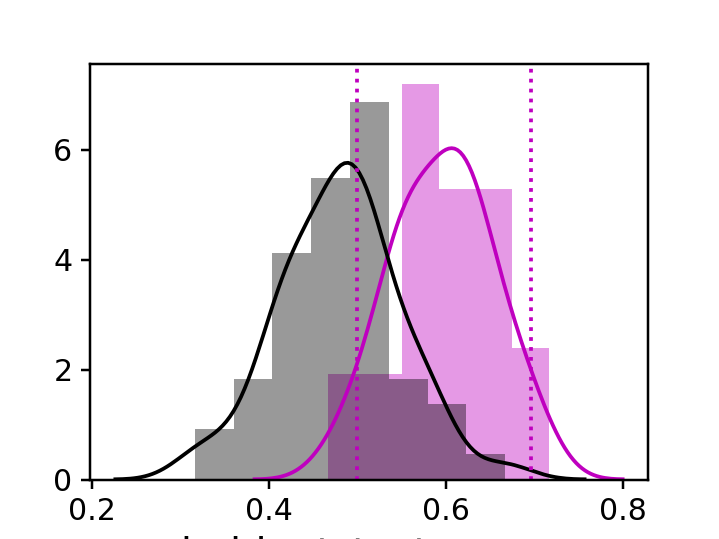

In [183]:
metric='heldout_test_score'
ci=0.95

tru_df = iter_results[iter_results['condition']=='data'].copy()
shu_df = iter_results[iter_results['condition']=='shuffled'].copy()

print('True: %.2f (Shuffled; %.2f)' % (tru_df[metric].mean(), shu_df[metric].mean()))

f, ax = pl.subplots(figsize=(4,3))
sns.distplot(tru_df[metric], color='m', label='data')
sns.distplot(shu_df[metric], color='k', label='shuffled')

ci_lo, ci_hi = putils.get_empirical_ci(tru_df[metric].values, ci=ci)
ax.axvline(x=ci_lo, linestyle=':', c='m')
ax.axvline(x=ci_hi, linestyle=':', c='m')

In [122]:
#### Combine into stacked df
NDATA = aggr.neuraldf_dict_to_dataframe(NEURALDATA)
NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

counts = NDATA[['visual_area', 'datakey', 'cell']]\
            .drop_duplicates().groupby(['visual_area', 'datakey']).count().reset_index()


In [124]:
counts[counts['visual_area']=='Ll']

,visual_area,datakey,cell
18,Ll,20190319_JC067_fov1,143
19,Ll,20190320_JC067_fov1,117
20,Ll,20190612_JC099_fov1,33


# Get global cells

In [16]:
remove_too_few = True
min_ncells=5
# overlap_thr=0.5

####
if overlap_thr is not None:
    #### Calculate overlap with stimulus
    stim_overlaps = rfutils.calculate_overlaps(RFDATA, experiment=experiment)
    
    #### Get global-indexed cells
    globalcells, cell_counts = aggr.get_pooled_cells(stim_overlaps, 
                                        remove_too_few=remove_too_few,
                                        overlap_thr=overlap_thr, min_ncells=min_ncells,
                                        return_counts=True)
else:
    globalcells, cell_counts = aggr.global_cells(cells, remove_too_few=remove_too_few, 
                                        min_ncells=min_ncells, return_counts=True)
    

Assigned visual areas: [u'Li' u'Ll' u'Lm' u'V1']


In [17]:
if overlap_thr is not None:
    pass_overlaps = stim_overlaps[stim_overlaps['perc_overlap']>=overlap_thr].copy()
    counts_by_dset = aggr.get_counts_by_datakey(pass_overlaps)
    
else:
    counts_by_dset = aggr.get_counts_by_datakey(cells)
counts_by_dset.groupby(['visual_area']).sum()

,n_cells,fovnum
visual_area,,
Li,1142,18
Ll,293,3
Lm,1970,18
V1,2089,16


<IPython.core.display.Javascript object>


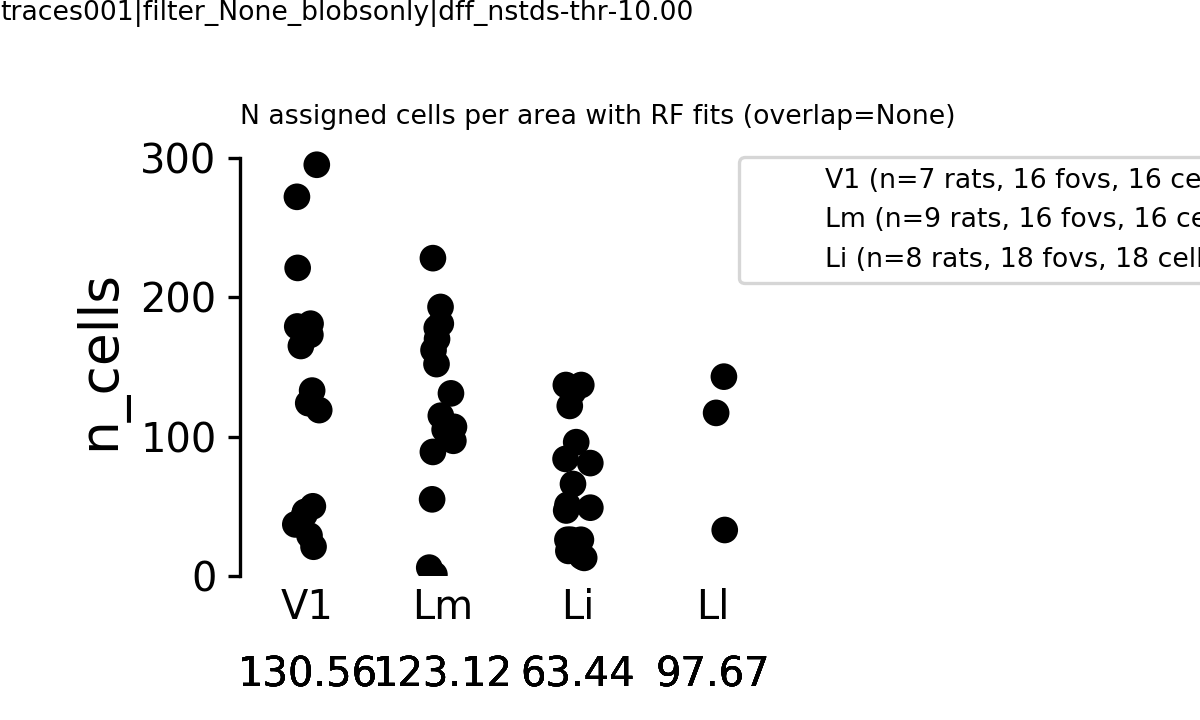

In [18]:
f, ax = pl.subplots(dpi=dpi, figsize=(5,3))
sns.stripplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='k', s=8, alpha=1)
sns.barplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='w', errcolor='w')
counts_by_dset.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))


ax.tick_params(which='both', axis='x', size=0)
ax.set_ylim([0, ax.get_ylim()[-1]])
sns.despine(bottom=True, trim=True, ax=ax)

ax.set_xlabel('')
pl.subplots_adjust(left=0.2, bottom=0.2, top=0.8)
ax.set_title("N assigned cells per area with RF fits (overlap=%s)" % str(overlap_thr), loc='left', fontsize=8)
putils.label_figure(f, data_id)

leg = aggr.get_counts_for_legend(counts_by_dset, markersize=0, lw=0)
ax.legend(handles=leg, bbox_to_anchor=(0.9,1), fontsize=8)
pl.subplots_adjust(left=0.2, right=0.65, bottom=0.2)

figname = 'ncells_assigned_with_rfs__%s-%s__%s' % (response_type, responsive_test, match_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


# Decode

In [19]:
test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


#### Test boot

In [20]:
visual_area = 'Li'
datakey = '20190602_JC091_fov1'

# visual_area = 'Lm'
# datakey = '20190306_JC061_fov3'

curr_ncells = 1
sdf = SDF[datakey].copy()
gdf = globalcells[(globalcells['visual_area']==visual_area)
                 & (globalcells['datakey']==datakey)].copy() # globalcells for current visual_area

#rid = 2
#rid in gdf['dset_roi']
curr_rois = gdf['dset_roi'].unique()
print('%i cells found (%s, %s)' % (len(curr_rois), datakey, visual_area))

137 cells found (20190602_JC091_fov1, Li)


#### Test boot iter for 1 cell

In [103]:
rid = 355.0

curr_data = NEURALDATA[visual_area][datakey][[rid, 'config']].copy()
print(curr_data.shape)
assert len(curr_data['config'].value_counts().unique())==1, \
        "(%s) ERR: uneven trial counts by config" % datakey


n_morphs = 10 #len(sdf['morphlevel'].unique())
stimmat = curr_data.groupby(['config']).mean().values.reshape((n_morphs, 5)).T
pl.figure(figsize=(4,3))
pl.imshow(stimmat)

(1450, 2)


#### Run bootstrap for 1 cell

In [105]:
test_split=0.2
i = decutils.fit_svm_mp(curr_data, sdf, C_value=None, 
                       n_iterations=50, n_processes=2,
                       verbose=False, class_a=0, class_b=106, test_split=test_split)
iterdf = pd.concat(i, axis=0)

True: 0.48 (Shuffled; 0.50)


<IPython.core.display.Javascript object>


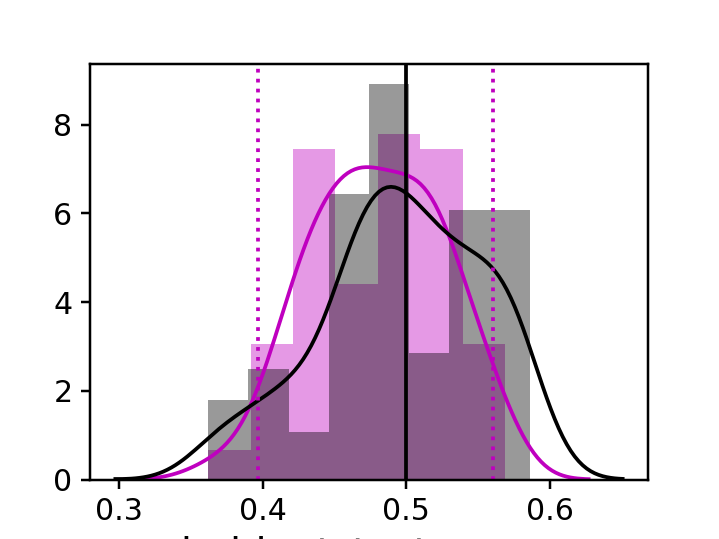

In [106]:
metric='heldout_test_score'
ci=0.95

tru_df = iterdf[iterdf['condition']=='data'].copy()
shu_df = iterdf[iterdf['condition']=='shuffled'].copy()

print('True: %.2f (Shuffled; %.2f)' % (tru_df[metric].median(), shu_df[metric].median()))

f, ax = pl.subplots(figsize=(4,3))
sns.distplot(tru_df[metric], color='m', label='data')
sns.distplot(shu_df[metric], color='k', label='shuffled')

ci_lo, ci_hi = putils.get_empirical_ci(tru_df[metric].values, ci=ci)
ax.axvline(x=ci_lo, linestyle=':', c='m')
ax.axvline(x=ci_hi, linestyle=':', c='m')

ax.axvline(x=0.5, linestyle='-', c='k')

## Break down each step

In [96]:
import random
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [18]:
class_a=0
class_b=106
print(datakey, rid)

curr_data = NEURALDATA[visual_area][datakey][[rid, 'config']].copy()
print(curr_data.shape)

sdf = SDF[datakey].copy()
sdf.head()

NameError: name 'datakey' is not defined

In [26]:
train_configs = sdf[sdf['morphlevel'].isin([class_a, class_b])].index.tolist()

#### Get trial data for selected cells and config types
curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
sample_data = curr_data[curr_data['config'].isin(train_configs)]
zdata = sample_data.drop('config', 1)


In [27]:
class_a_configs = sdf[sdf['morphlevel']==class_a].index.tolist()
class_b_configs = sdf[sdf['morphlevel']==class_b].index.tolist()

In [28]:
total_class_a = sample_data[sample_data['config']\
                            .isin(class_a_configs)]['config'].value_counts().sum()

total_class_b = sample_data[sample_data['config']\
                            .isin(class_b_configs)]['config'].value_counts().sum()
assert total_class_a==total_class_b, \
    "Classes are impbalanced: A=%i trials, B=%i trials" % (total_class_a, total_class_b)

In [29]:

#### Get labels
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]


<IPython.core.display.Javascript object>


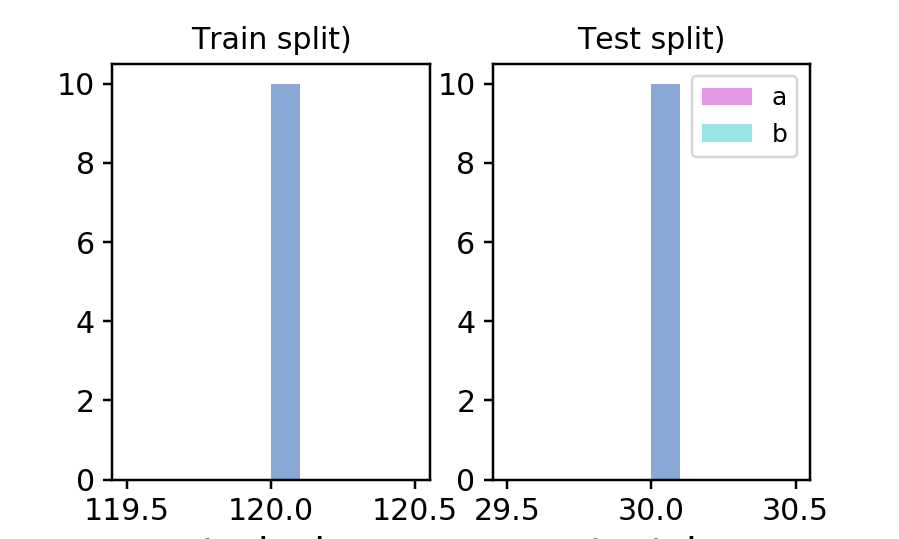

In [31]:
test_split=0.2
cnts = []
for i in np.arange(0, 100):
    randi = random.randint(1, 90000)
    #print(randi)
    #### For each transformation, split trials into 80% and 20%
    train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                    targets['label'].values,
                                                    test_size=test_split,
                                                    stratify=targets['label'], #targets['group'],
                                                    shuffle=True, random_state=randi)

    n_train_a = len(np.where(train_labels==class_a)[0])
    n_train_b = len(np.where(train_labels==class_b)[0])
    #print("Train: a=%i, b=%i" % (n_train_a, n_train_b))
    n_test_a = len(np.where(test_labels==class_a)[0])
    n_test_b = len(np.where(test_labels==class_b)[0])
    #print("Test: a=%i, b=%i" % (n_test_a, n_test_b))

    cnt = pd.Series({'train_a': n_train_a, 'train_b': n_train_b, 
                      'test_a': n_test_a, 'test_b': n_test_b})
    cnts.append(cnt)
cnts = pd.concat(cnts, axis=1).T

fig, axn= pl.subplots(1,2, figsize=(5,3))
ax=axn[0]
sns.distplot(cnts['train_a'], color='m', label='a', ax=ax)
sns.distplot(cnts['train_b'], color='c', label='b', ax=ax)
ax.set_title("Train split)")
ax=axn[1]
sns.distplot(cnts['test_a'], color='m', label='a')
sns.distplot(cnts['test_b'], color='c', label='b')
ax.set_title("Test split)")
pl.legend()

In [246]:
verbose=False
cv_nfolds=5
test_split=0.2


r_=[]
for i in np.arange(0, 100):
    
    randi = random.randint(1, 90000)
    #### For each transformation, split trials into 80% and 20%
    train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                targets['label'].values,
                                                test_size=test_split,
                                                stratify=targets['label'], #targets['group'],
                                                shuffle=True, random_state=randi)
    #### Use TRAIN set to fit C
    cv_grid = decutils.tune_C(train_data, train_labels, scoring_metric='accuracy',
                       cv_nfolds=cv_nfolds, test_split=test_split, verbose=verbose) 
    C_value = cv_grid.best_params_['C'] 

    #### Fit SVM with best C
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)

    svc = svm.SVC(kernel='linear', C=C_value, random_state=randi) 
    scores = cross_validate(svc, train_data, train_labels, cv=cv_nfolds,
                            scoring=('accuracy'), return_train_score=True)
    iterdict = dict((s, values.mean()) for s, values in scores.items())
    if verbose:
        print('... train (C=%.2f): %.2f, test: %.2f' \
              % (C_value, iterdict['train_score'], iterdict['test_score']))  
    trained_svc = svc.fit(train_data, train_labels)

    #### DATA - Test with held-out data
    test_data = scaler.transform(test_data)
    test_score = trained_svc.score(test_data, test_labels)

    # ------------------------------------------------------------------
    # Shuffle LABELS to calculate chance level
    train_labels_chance = train_labels.copy()
    np.random.shuffle(train_labels_chance)
    test_labels_chance = test_labels.copy()
    np.random.shuffle(test_labels_chance)

    # New C?
    cv_grid_ch = decutils.tune_C(train_data, train_labels_chance, scoring_metric='accuracy',
                        cv_nfolds=cv_nfolds, test_split=test_split, verbose=verbose) 
    C_value_ch = cv_grid_ch.best_params_['C'] 

    #### CHANCE - Fit classifier
    chance_svc = svm.SVC(kernel='linear', C=C_value_ch, random_state=randi)
    scores_chance = cross_validate(chance_svc, train_data, train_labels_chance, 
                            cv=cv_nfolds, scoring=('accuracy'), return_train_score=True)
    iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

    # CHANCE - Test with held-out data
    trained_svc_chance = chance_svc.fit(train_data, train_labels_chance)
    test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)
    
    tst = pd.Series({'shuffle_train': iterdict_chance['train_score'], 
                     'shuffle_cv': iterdict_chance['test_score'], 
                     'shuffle_C': C_value_ch, 
                     'shuffle_test': test_score_chance,
                     'train': iterdict['train_score'],
                     'cv': iterdict['test_score'],
                     'C': C_value,
                     'test': test_score, 
                     'randi': randi})
    r_.append(tst)
results = pd.concat(r_, axis=1).T


Process PoolWorker-11826:
Process PoolWorker-11827:
Process PoolWorker-11829:
Process PoolWorker-11816:
Process PoolWorker-11819:
Process PoolWorker-11817:
Process PoolWorker-11824:
Process PoolWorker-11820:
Process PoolWorker-11823:
Process PoolWorker-11811:
Process PoolWorker-11828:
Process PoolWorker-11815:
Process PoolWorker-11812:
Process PoolWorker-11818:
Process PoolWorker-11825:
Process PoolWorker-11813:
Process PoolWorker-11814:
Process PoolWorker-11821:
Process PoolWorker-11822:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most 

    task = get()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
    task = get()
    task = get()
    task = get()
    task = get()
    task = get()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    task = get()
    task = get()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    task = get()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    task = get()
    task = get()
    task = get()
    task = get()
  File "/n/coxfs01/2p-pipeline/envs

KeyboardInterrupt: 

In [ ]:
results.head()

In [ ]:
fig, axn= pl.subplots(1,3, figsize=(6,3), sharex=True)
ax=axn[0]
sns.distplot(results['train'].values, color='m', label='train', ax=ax)
sns.distplot(results['shuffle_train'].values, color='k', label='shuffled', ax=ax)
ax.set_title('Train')
ax.axvline(x=0.5, color='k', ls=':')

ax=axn[1]
sns.distplot(results['cv'].values, color='c', label='test', ax=ax)
sns.distplot(results['shuffle_cv'].values, color='k', label='shuffled', ax=ax)
ax.set_title("CV results")
ax.axvline(x=0.5, color='k', ls=':')

ax=axn[2]
sns.distplot(results['test'], color='m', ax=ax)
sns.distplot(results['shuffle_test'], color='k', ax=ax)
ax.set_title("Test")
ax.axvline(x=0.5, color='k', ls=':')

pl.subplots_adjust(bottom=0.2, hspace=0.5, wspace=0.5)

In [55]:
results['test'].median()

0.65

In [53]:
n_train_a = len(np.where(train_labels_chance==class_a)[0])
n_train_b = len(np.where(train_labels_chance==class_b)[0])
print("Train: a=%i, b=%i" % (n_train_a, n_train_b))
n_test_a = len(np.where(test_labels_chance==class_a)[0])
n_test_b = len(np.where(test_labels_chance==class_b)[0])
print("Test: a=%i, b=%i" % (n_test_a, n_test_b))

Train: a=120, b=120
Test: a=30, b=30


#### Cycle thru all cells in curr fov

In [71]:
rid in curr_rois[0::5]

True

In [72]:
d_list=[]
for ri, rid in enumerate(curr_rois[0::5]):
    #print('...%i of %i cells' % (int(ri+1), len(curr_rois)))
    curr_data = NEURALDATA[visual_area][datakey][[rid, 'config']].copy()
    i = decutils.fit_svm_mp(curr_data, sdf, C_value=None, 
                           n_iterations=50, n_processes=2,
                           verbose=False, class_a=0, class_b=106)
    
    iterdf = pd.concat(i, axis=0)
    meanscore = iterdf[iterdf['condition']=='data'][metric].mean()
    #print('%i: %.2f' % (rid, meanscore))
    iterdf['rid'] = rid
    d_list.append(iterdf)
    
df = pd.concat(d_list, axis=0)
print(df.shape, iterdf.shape, df.shape)

10: 0.51
15: 0.55
24: 0.54
32: 0.45
38: 0.45
47: 0.66
62: 0.54
69: 0.45
79: 0.54
86: 0.46
94: 0.45
166: 0.65
171: 0.52
180: 0.45
201: 0.46
209: 0.52
215: 0.57
221: 0.47
227: 0.48
236: 0.52
243: 0.49
251: 0.50
259: 0.46
268: 0.61
279: 0.54
288: 0.45
295: 0.55
310: 0.46
318: 0.52
327: 0.58
340: 0.58
347: 0.53
355: 0.61
360: 0.53
378: 0.51


NameError: name 'df_' is not defined

<IPython.core.display.Javascript object>


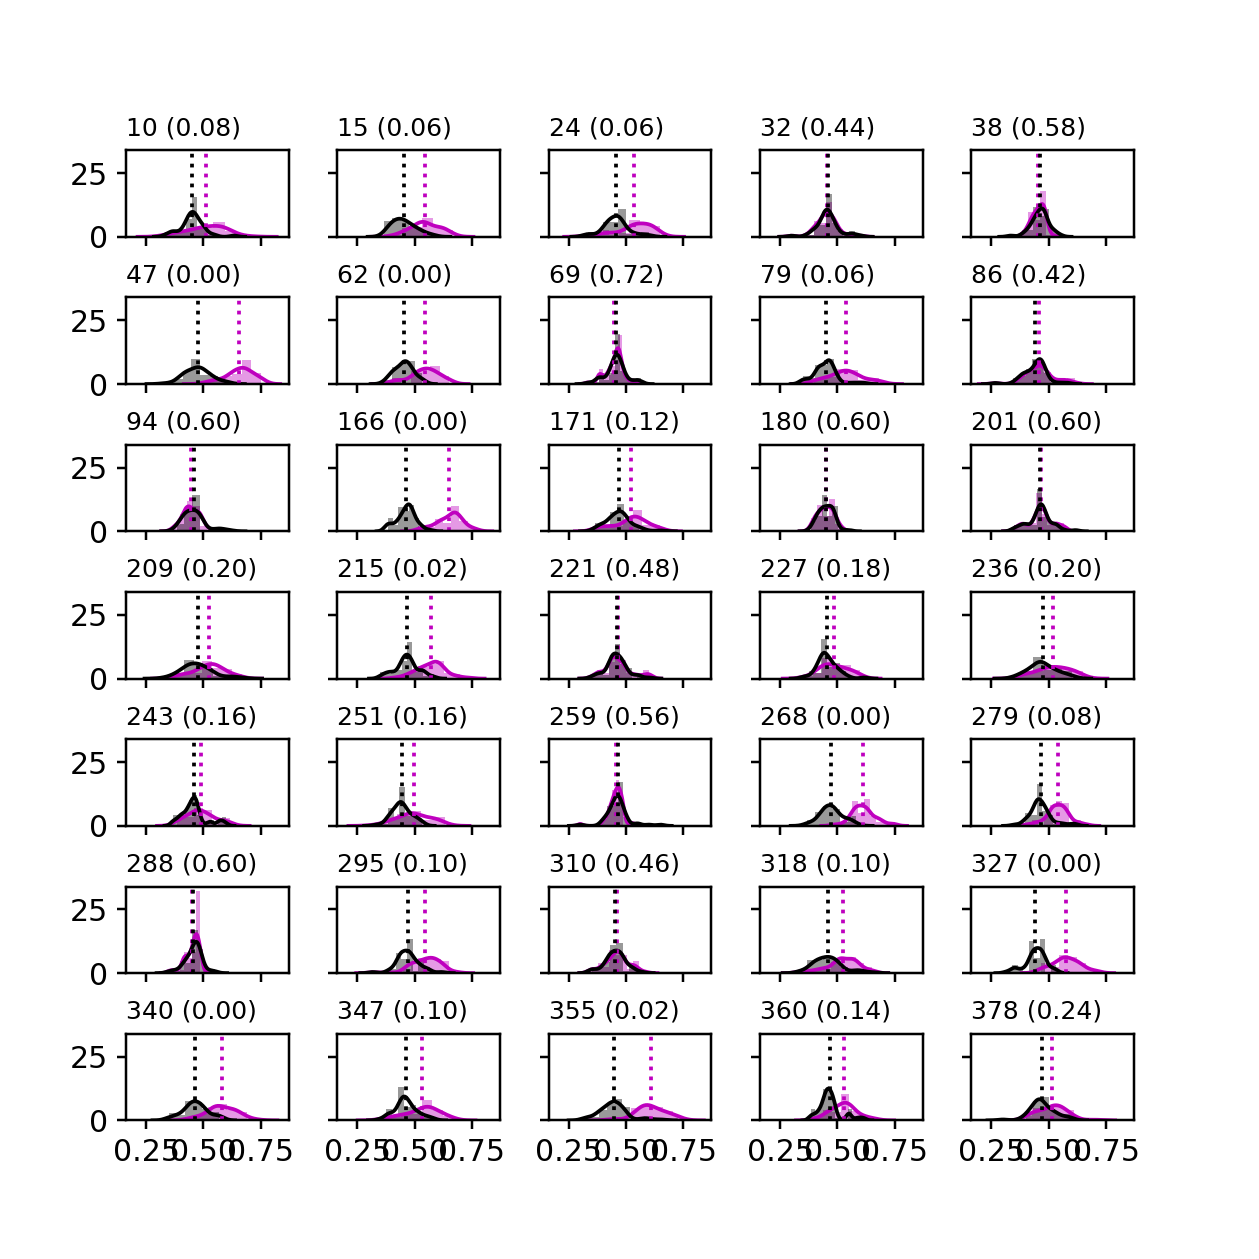

In [101]:
f, axn = pl.subplots(7, 5, figsize=(7,7), sharex=True, sharey=True)
for ax, (rid, xdf) in zip(axn.flat, df.groupby(['rid'])):
    tru_df = xdf[xdf['condition']=='data'].copy()
    shu_df = xdf[xdf['condition']=='shuffled'].copy()

    mean_score = tru_df[metric].mean()
    shuff_score = shu_df[metric].mean()
    
    score_percentile = np.mean(mean_score < shu_df[metric])
    #meandiff = tru_df[metric].mean() - shu_df[metric].mean()

    sns.distplot(tru_df[metric], color='m', label='data', ax=ax)
    sns.distplot(shu_df[metric], color='k', label='shuffled', ax=ax)
    ax.axvline(x=mean_score, linestyle=':', c='m')
    ax.axvline(x=shuff_score, linestyle=':', c='k')
    
    #ci_lo, ci_hi = putils.get_empirical_ci(tru_df[metric].values, ci=ci)
    #ax.axvline(x=ci_hi, linestyle=':', c='m')
    
    ax.set_title("%i (%.2f)" % (rid, score_percentile), loc='left', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
pl.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9)

True: 0.52
Shuffled: 0.46


<IPython.core.display.Javascript object>


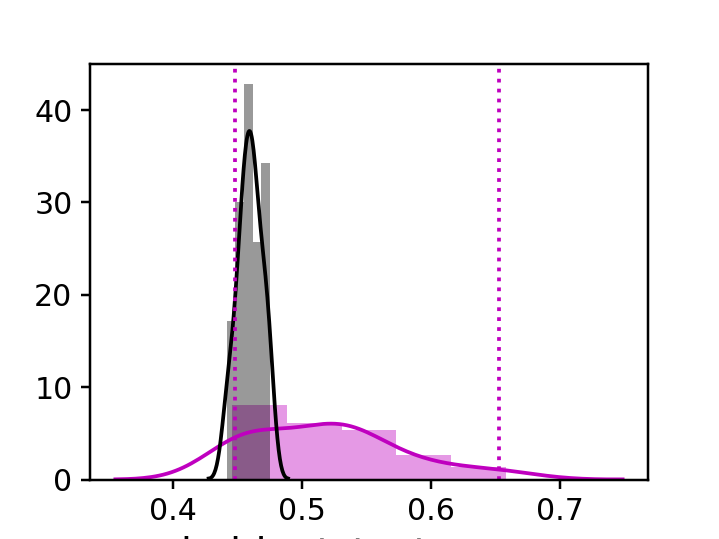

In [85]:
meandf = df.groupby(['condition', 'rid']).mean().reset_index()

xdf = meandf.copy()
tru_df = xdf[xdf['condition']=='data'].copy()
shu_df = xdf[xdf['condition']=='shuffled'].copy()

print('True: %.2f' % tru_df[metric].median())
print('Shuffled: %.2f' % shu_df[metric].median())

f, ax = pl.subplots(figsize=(4,3))
sns.distplot(tru_df[metric], color='m', label='data')
sns.distplot(shu_df[metric], color='k', label='shuffled')

ci_lo, ci_hi = putils.get_empirical_ci(tru_df[metric].values, ci=ci)
ax.axvline(x=ci_lo, linestyle=':', c='m')
ax.axvline(x=ci_hi, linestyle=':', c='m')

# Aggregate single cell results for 1 FOV

In [21]:
def check_old_naming(animalid, session, fov, experiment='blobs', traceid='traces001',
                decode_type='single_cells', sub_dir='dff-nstds_stimulus', C_str='tuneC',
                rootdir='/n/coxfs01/2p-data'):
    
    res_files = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', decode_type, sub_dir, '*%s*.pkl' % C_str))
    for r in res_files:
        curr_dir, fname = os.path.split(r)
        if fname.startswith('single_cells_'):
            new_name = fname.split('single_cells_')[-1]
            os.rename(r, os.path.join(curr_dir, new_name))
    return


In [22]:
def load_cell_results_from_fov(animalid, session, fov, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', 
                               rootdir='/n/coxfs01/2p-data'):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    sub_dir = '%s-%s_%s' % (response_type, responsive_test, trial_epoch)

    C_str = 'tuneC' if C_value is None else 'C%.2f' % C_value
    check_old_naming(animalid, session, fov, experiment=experiment, traceid=traceid,
                     decode_type='single_cells', sub_dir=sub_dir, C_str=C_str)
    
    cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))
    rlist=[]
    for c in cell_results:
        with open(c, 'rb') as f:
            res = pkl.load(f)

        res['iteration'] = res.index.tolist()
        res = res.reset_index(drop=True).sort_values(by='iteration')
        rlist.append(res)
        
    if len(rlist)>0:
        roidf = pd.concat(rlist, axis=0)
        
    result_id = '%s_%s' % (sub_dir, C_str)
    
    return roidf, result_id


In [33]:
def plot_true_and_shuffled_distns(meandf, metric='heldout_test_score', return_scores=True, ax=None):
    '''
    Takes 
    '''
    
    tru_df = meandf[meandf['condition']=='data']
    shu_df = meandf[meandf['condition']=='shuffled']

    mean_score = tru_df[metric].mean()
    shuffled_score = shu_df[metric].mean()
    score_percentile = np.mean(mean_score < shu_df[metric])
    #print('%.2f, %.2f' % (mean_score, shuffled_score))

    # PLOT
    if ax is None:
        fig, ax = pl.subplots()
    sns.distplot(tru_df[metric], ax=ax, color='m')
    sns.distplot(shu_df[metric], ax=ax, color='k')
    ax.axvline(x=mean_score, linestyle=':', color='m')
    ax.axvline(x=shuffled_score, linestyle=':', color='k')
    
    if return_scores:
        return ax, mean_score, score_percentile
    else:
        return ax
    
    

In [77]:

def stripplot_by_area(metric, data_df, ax=None, area_colors=None, size=5,
                     visual_areas=['V1', 'Lm', 'Li', 'Ll'], scale=2, bar=True):
    if ax is None:
        fig, ax = pl.subplots()
        
    if area_colors is None:
        cols = sns.color_palette('colorblind', n_colors=len(visual_areas))
        area_colors = dict((v, c) for v, c in zip(visual_areas, cols))    
    
    if bar:
        sns.barplot(x='visual_area',  y=metric, data=data_df, ax=ax,
                           order=visual_areas,
                           zorder=0, edgecolor='none', facecolor='none', color='none')

    sns.stripplot(x='visual_area',  y=metric, data=data_df, ax=ax,
               order=visual_areas, hue='visual_area',
               zorder=1, size=2, palette=area_colors)

    sns.pointplot(x='visual_area',  y=metric, data=data_df, ax=ax, join=False,
               order=visual_areas, markers='_', color='k', # palette=area_colors,
               scale=1, zorder=1000)
    return ax


In [23]:
rootdir='/n/coxfs01/2p-data'
traceid='traces001'
experiment='blobs'
# -----------------------------------------------------
response_type='dff'
responsive_test='nstds'
# -----------------------------------------------------

In [24]:
#datakey = '20190316_JC070_fov1'

overlap_thr = None
C_value=None
trial_epoch = 'plushalf'


##### Test for 1 fov

In [27]:
animalid = 'JC091'
session = '20190602'
fovnum=1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
visual_area='Li'
fov = 'FOV%i_zoom2p0x' % fovnum

# curr_ncells = globalcells[(globalcells['datakey']==datakey) & (globalcells['visual_area']==visual_area)].shape
roidf, results_id = load_cell_results_from_fov(animalid, session, fov, experiment, traceid=traceid,
                                   C_value=None, trial_epoch=trial_epoch,
                                   response_type=response_type, responsive_test=responsive_test,
                                   rootdir=rootdir)
curr_ncells = roidf.shape[0]
metainfo = {'datakey': datakey, 'visual_area': visual_area}
roidf = putils.add_meta_to_df(roidf, metainfo)

(7800, 16)
dff-nstds_plushalf_tuneC


<IPython.core.display.Javascript object>


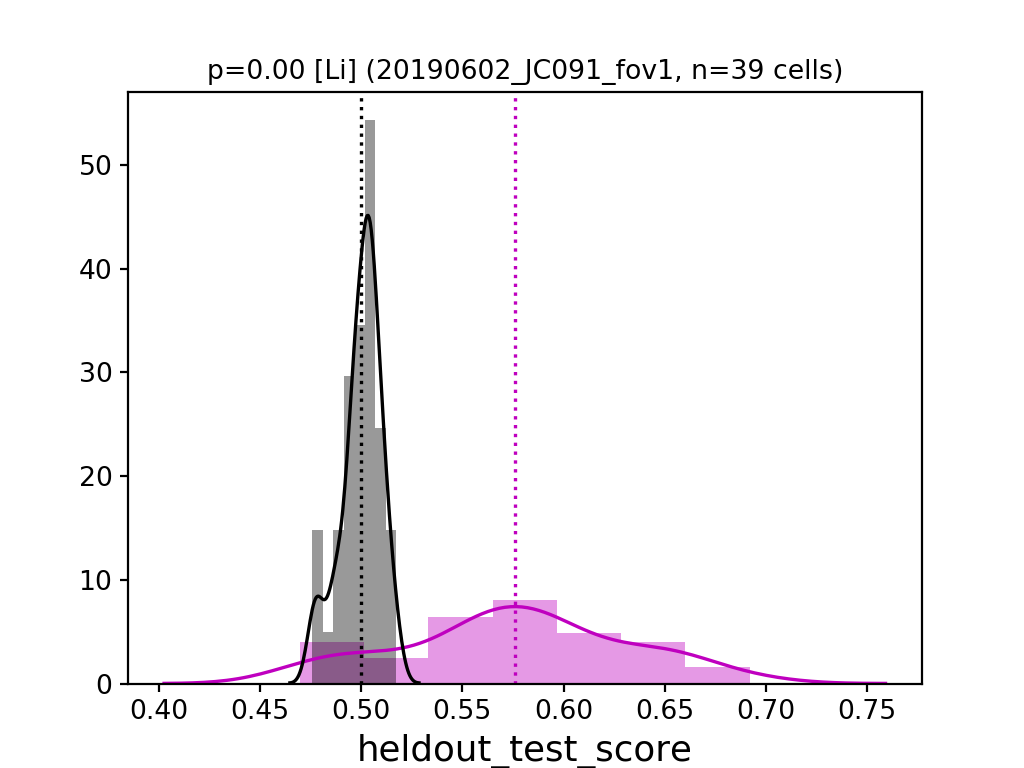

Text(0.5,1,u'p=0.00 [Li] (20190602_JC091_fov1, n=39 cells)')

In [36]:
metric = 'heldout_test_score'

means_by_cell = roidf.groupby(['cell', 'condition']).mean().reset_index()
curr_ncells = len(means_by_cell['cell'].unique())

# PLOT
fig, ax = pl.subplots()
ax, mean_score, score_percentile = plot_true_and_shuffled_distns(means_by_cell, ax=ax,
                                                                 metric=metric, return_scores=True)
ax.set_title("p=%.2f [%s] (%s, n=%i cells)" \
             % (score_percentile, visual_area, datakey, curr_ncells))

# Aggregate all single cell results

In [159]:
overlap_thr = None
C_value=None
trial_epoch = 'plushalf'
# ----------------------------------------
print(results_id)

r_list=[]
for (visual_area, animalid, session, fovnum, datakey), g \
    in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
    roidf, results_id = load_cell_results_from_fov(animalid, session, 
                            'FOV%i_zoom2p0x' % fovnum, experiment,
                             C_value=None, trial_epoch=trial_epoch,
                             response_type=response_type, 
                            responsive_test=responsive_test)
    
    if roidf is None:
        # print("[%s] %s - No cells." % (visual_area, datakey))
        continue
    curr_ncells = len(roidf['cell'].unique()) #.shape[0]
    # print("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))
    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)
singledf = pd.concat(r_list, axis=0)

In [144]:
itermean = singledf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


counts_by_fov = itermean[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov.groupby(['visual_area']).sum()

## Filter cells that don't pass 

In [160]:
s_=[]
for (visual_area, datakey, rid), d_ in singledf.groupby(['visual_area', 'datakey', 'cell']):
                            
    mean_score = d_[d_['condition']=='data'][metric].mean()
    percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
    
    s = pd.Series({'visual_area': visual_area, 'datakey': datakey, 'cell': rid, 
                   'mean_score': mean_score, 'percentile': percentile})
    s_.append(s)
    
scores_by_cell = pd.concat(s_, axis=1).T.reset_index(drop=True)

In [161]:
p_thr=0.01
pass_scores = scores_by_cell[scores_by_cell['percentile']<p_thr].copy()
pass_scores['mean_score'] = pass_scores['mean_score'].astype(float)

pass_scores.groupby(['visual_area']).mean()

,mean_score
visual_area,
Li,0.600713
Ll,0.592281
Lm,0.590060
V1,0.607091


In [162]:
df = pd.concat([itermean[(itermean['visual_area']==visual_area) & (itermean['datakey']==datakey)] \
            for (visual_area, datakey), g in pass_scores.groupby(['visual_area', 'datakey'])], axis=0)\
    .reset_index(drop=True)

<IPython.core.display.Javascript object>


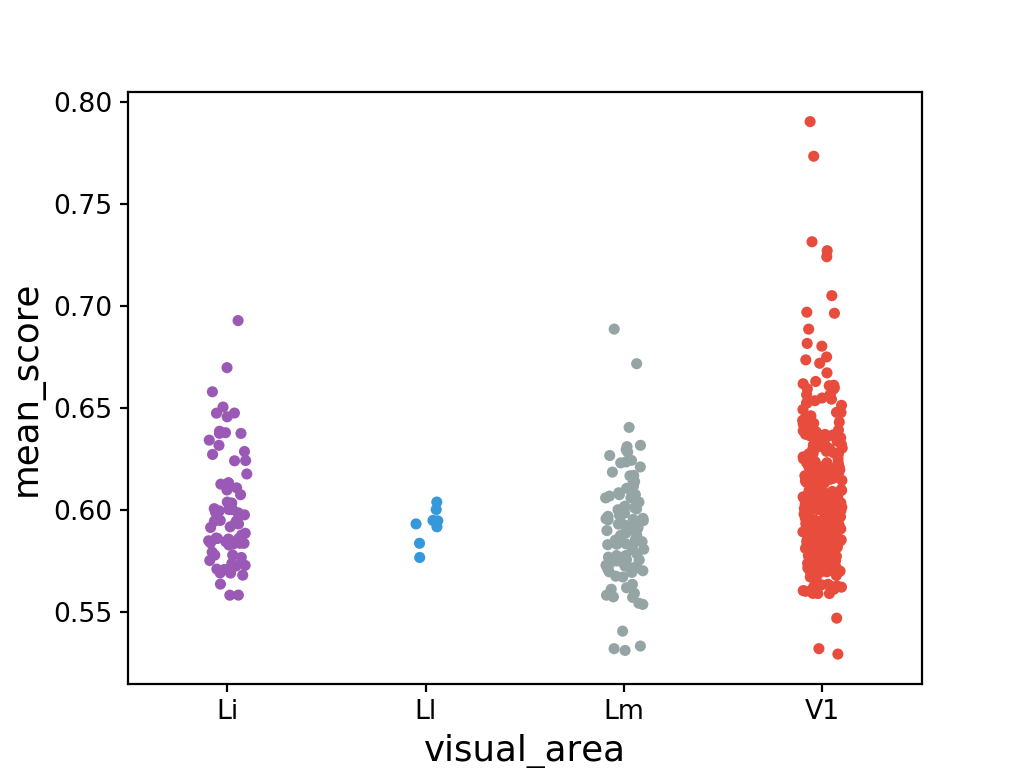

In [163]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='mean_score', data=pass_scores, ax=ax)

In [164]:
min_ncells=5
curr_dkeys = counts_by_fov[counts_by_fov['cell']>=min_ncells]['datakey'].unique()
all_dkeys = counts_by_fov['datakey'].unique()
print("%i of %i dkeys pass (min_ncells=%i)" % (len(curr_dkeys), len(all_dkeys), min_ncells))

39 of 40 dkeys pass (min_ncells=5)


<IPython.core.display.Javascript object>


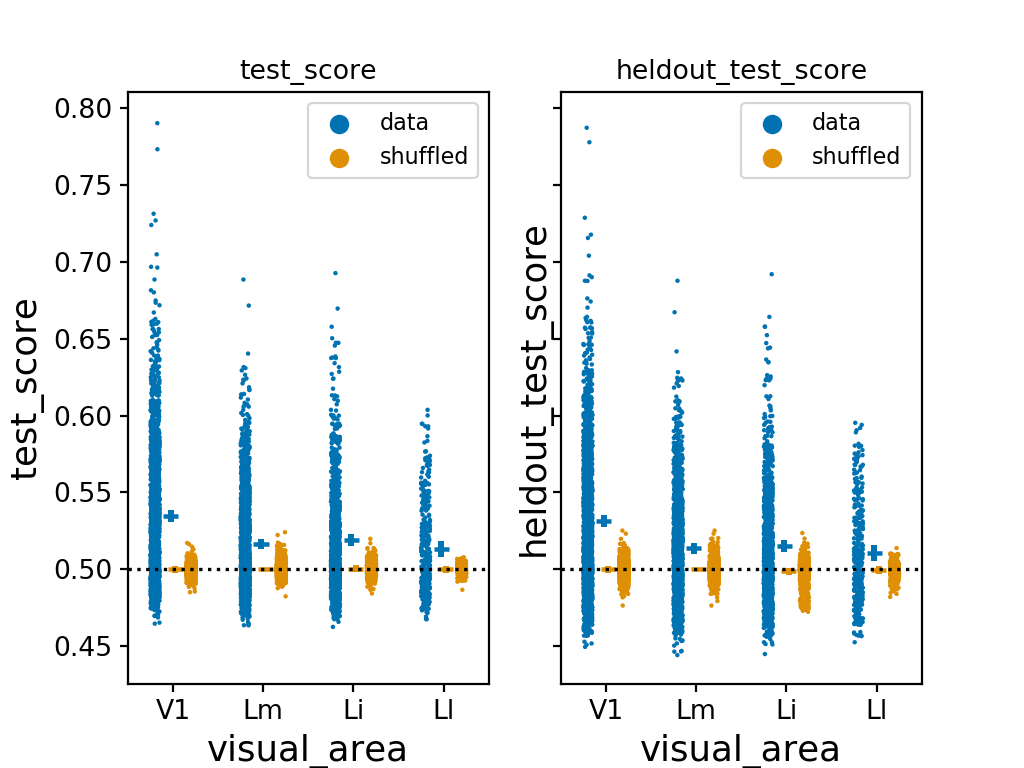

In [165]:
xdf = df[(df['datakey'].isin(curr_dkeys))]# & ~(df['datakey'].isin(ign))]
meandf = xdf.copy() #xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

fig, axn = pl.subplots(1, 2, sharey=True)
ax=axn[0]
metric='test_score'
ax.set_title(metric)
sns.stripplot(x='visual_area',  y=metric, data=meandf, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=meandf, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


ax=axn[1]
metric='heldout_test_score'
ax.set_title(metric)
sns.stripplot(x='visual_area',  y=metric, data=meandf, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=meandf, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


In [154]:
# meandf[(meandf['condition']=='shuffled') & (meandf[metric]<=0.476)].groupby(['visual_area', 'datakey']).mean()

#['datakey'].unique()
means_by_fov = meandf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
means_by_fov[means_by_fov[metric]<=0.476]

,visual_area,datakey,condition,cell,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,iteration,n_cells,n_trials,randi,score_time,test_score,train_score


In [155]:
# ign = means_by_fov[means_by_fov[metric]<=0.476]['datakey'].unique()

#### check bi distn

<IPython.core.display.Javascript object>


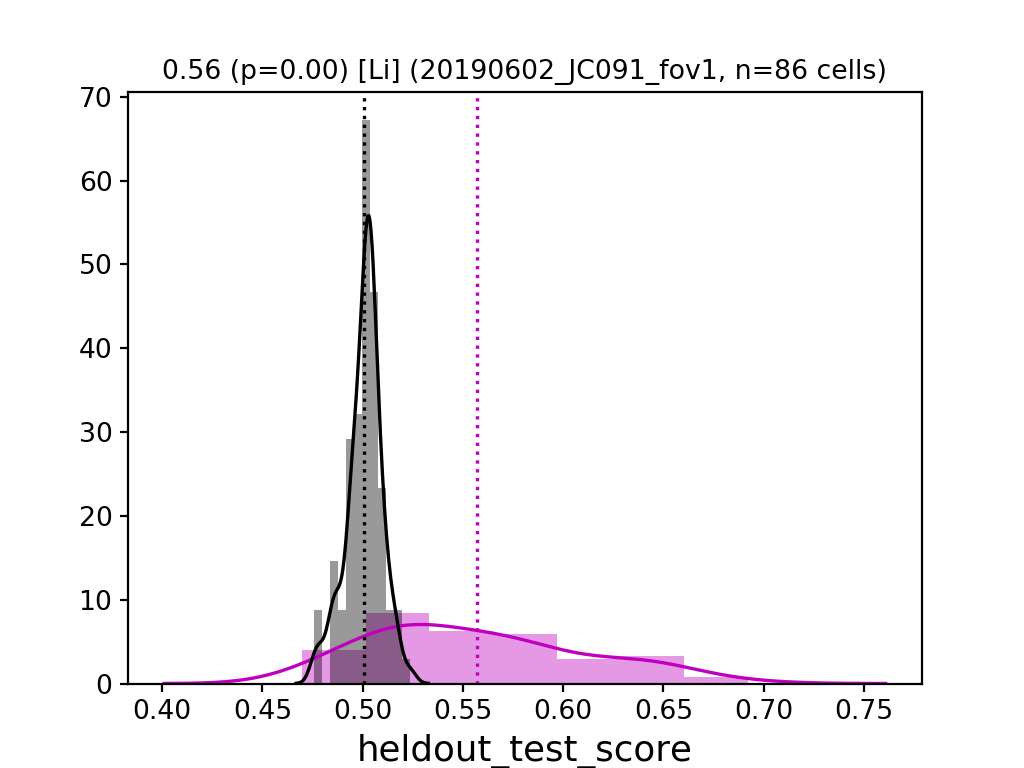

Text(0.5,1,u'0.56 (p=0.00) [Li] (20190602_JC091_fov1, n=86 cells)')

In [156]:
datakey = '20190602_JC091_fov1'
visual_area='Li'
d = singledf[(singledf['visual_area']==visual_area) 
             & (singledf['datakey']==datakey)].copy()

means_by_cell = d.groupby(['cell', 'condition']).mean().reset_index()
means_by_cell.shape

curr_ncells = len(means_by_cell['cell'].unique())

# PLOT
fig, ax = pl.subplots()
ax, mean_score, score_percentile = plot_true_and_shuffled_distns(means_by_cell, ax=ax,
                                                                 metric=metric, return_scores=True)
ax.set_title("%.2f (p=%.2f) [%s] (%s, n=%i cells)" \
             % (mean_score, score_percentile, visual_area, datakey, curr_ncells))

In [78]:
area_colors.update({'Ll': 'purple'})

<IPython.core.display.Javascript object>


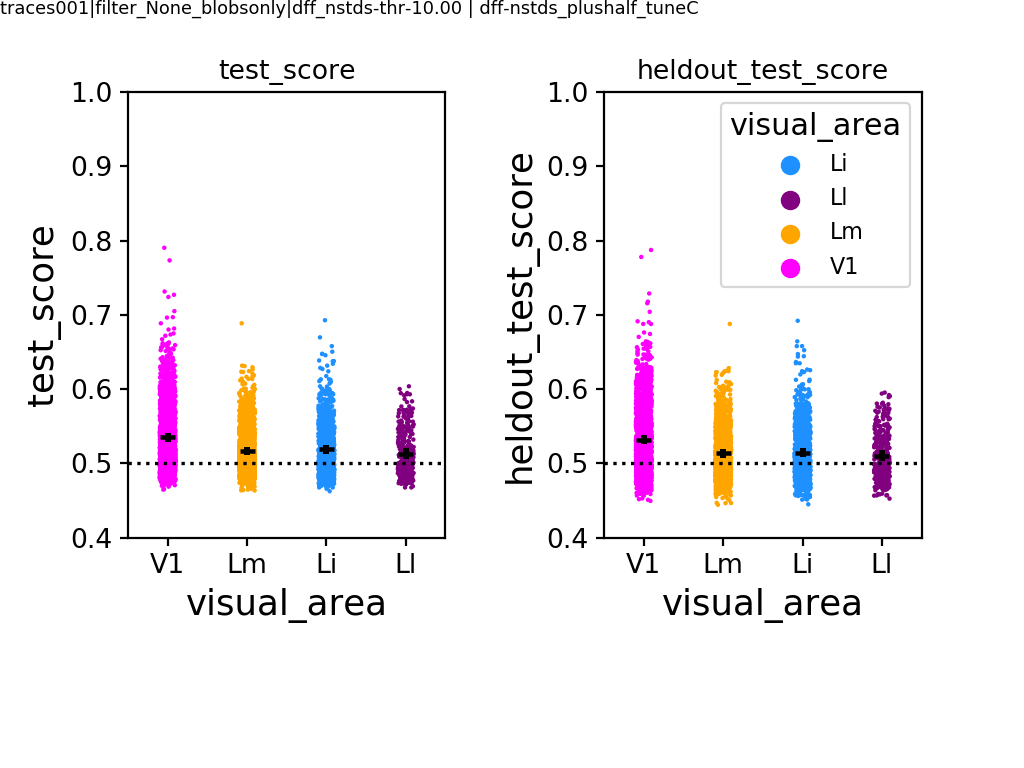

In [79]:
curr_metric = 'test_score'
xdf = singledf[(singledf['datakey'].isin(curr_dkeys)) & ~(singledf['datakey'].isin(ign))]
meandf = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()
data_df = meandf[meandf['condition']=='data'].copy()


fig, axn = pl.subplots(1, 2, sharey=False)
ax=axn[0]
metric='test_score' #curr_metric
ax.set_title(metric)
ax = stripplot_by_area(metric, data_df, ax=ax, area_colors=area_colors, 
                       size=2, bar=True)
#### Label
if 'test_score' in metric:
    ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, color='k', ls=':')
#data_df.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=(0, -10))

ax.legend_.remove()


ax=axn[1]
metric='heldout_%s' % curr_metric
ax.set_title(metric)
ax = stripplot_by_area(metric, data_df, ax=ax, area_colors=area_colors, size=2)

if 'test_score' in metric:
    ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, color='k', ls=':')
data_df.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=(0, -20))


putils.label_figure(fig, '%s | %s' % (data_id, results_id))
pl.subplots_adjust(bottom=0.3, wspace=0.5)

#### Compare scores by FOV

<IPython.core.display.Javascript object>


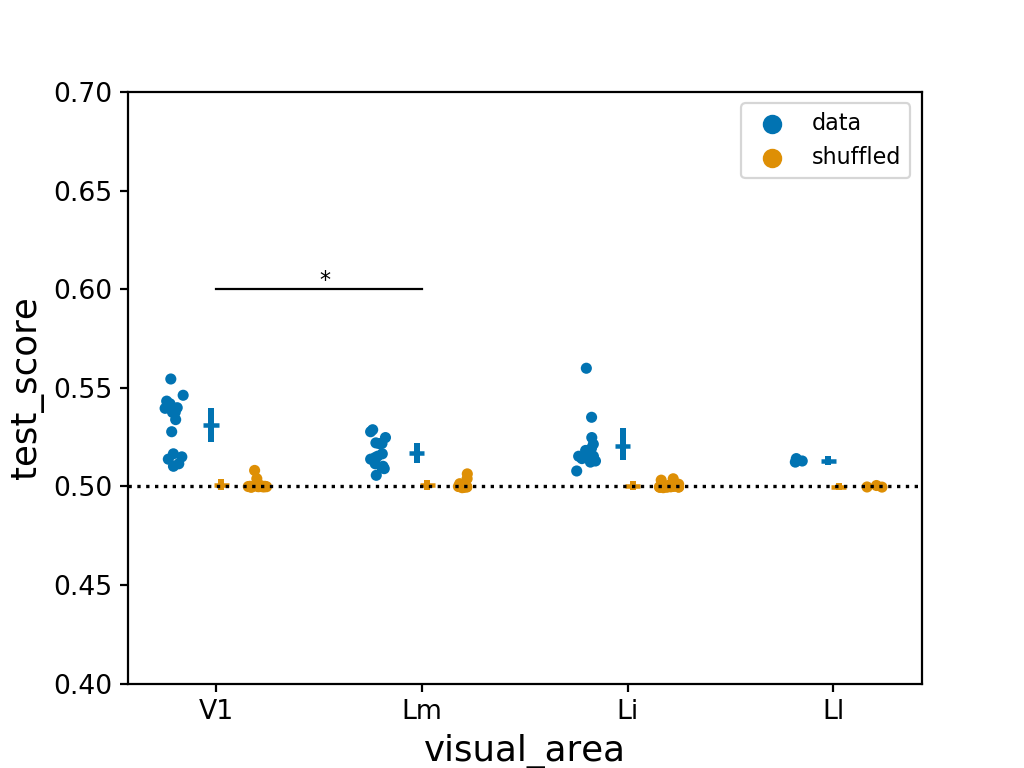

********* [test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.011 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.064 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.323 (fdr_bh), reject H0=False
****************************


(0.4, 0.7)

In [166]:
metric = 'heldout_test_score'
metric = 'test_score'
multi_comp_test='fdr_bh'
groupdf = meandf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()



fig, ax = pl.subplots( sharey=True)
sns.stripplot(x='visual_area',  y=metric, data=groupdf, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=5, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=groupdf, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')



    
#### Stats
statsresults, ax = aggr.plot_mannwhitney(groupdf[groupdf['condition']=='data'], 
                            metric=metric, multi_comp_test=multi_comp_test, 
                            ax=ax, y_loc=0.6, offset=0.01)
ax.set_ylim([0.4, 0.7])


In [75]:
# fig, ax = pl.subplots()
# sns.barplot(x='visual_area', y=metric, data=xdf, 
#            facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas, ax=ax)
# sns.swarmplot(x='visual_area', y=metric, data=xdf, ax=ax,
#              palette=area_colors,  order=visual_areas,)

# xdf.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=(0, -40))


<IPython.core.display.Javascript object>


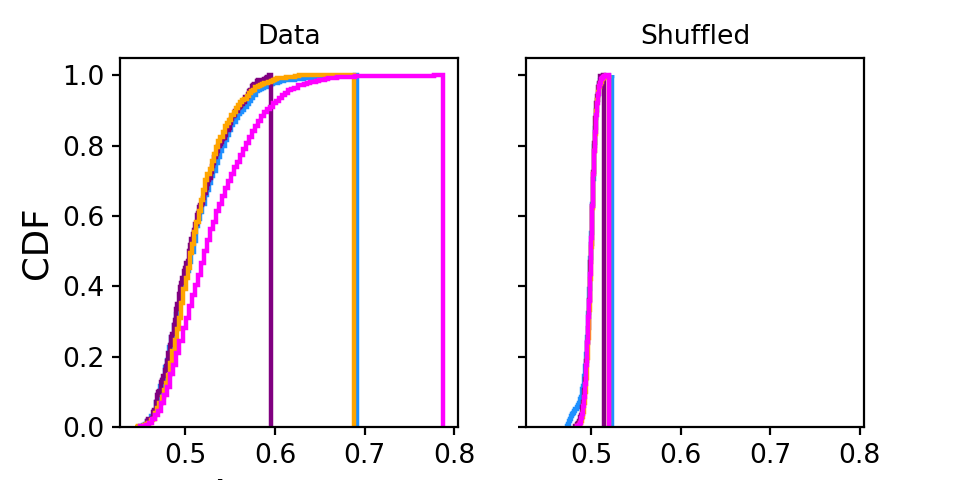

Text(0.5,1,u'Shuffled')

In [99]:
metric='heldout_test_score'
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)

ax=axn[0]
xdf = singledf[~(singledf['datakey'].isin(ign))].copy() 
means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


for visual_area, vdf in means_by_cell[means_by_cell['condition']=='data'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
ax.set_title('Data')
ax.set_ylabel('CDF')
ax.set_xlabel('Accuracy')

ax=axn[1]
for visual_area, vdf in means_by_cell[means_by_cell['condition']=='shuffled'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True, lw=2, bins=100)
ax.set_title('Shuffled')

<IPython.core.display.Javascript object>


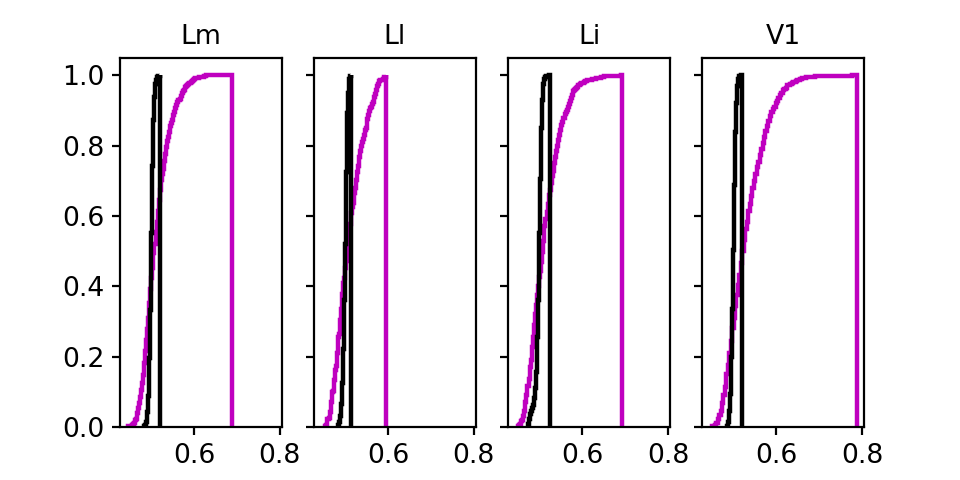

(u'Li', Ks_2sampResult(statistic=0.4696707105719238, pvalue=3.9504799758792587e-112))
(u'Ll', Ks_2sampResult(statistic=0.438953488372093, pvalue=8.887476305385559e-30))
(u'Lm', Ks_2sampResult(statistic=0.451198129748685, pvalue=5.527543340959283e-153))
(u'V1', Ks_2sampResult(statistic=0.6029106029106028, pvalue=1.3842212387758096e-306))


In [100]:
xdf = singledf[~(singledf['datakey'].isin(ign))].copy() 
means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


fig, axn = pl.subplots(1,4, figsize=(6,3), sharex=True, sharey=True)
for ai, (visual_area, vdf) in enumerate(means_by_cell.groupby(['visual_area'])):
    ax=axn[2-ai]
    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    
    print("%s" % visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))
    
    n, bins, patches = ax.hist(d1[metric].values, color='m',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    n, bins, patches = ax.hist(d2[metric].values, color='k',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    
    ax.set_title(visual_area)
    

In [101]:
for visual_area in visual_areas:
    vdf = means_by_cell[means_by_cell['visual_area']==visual_area]

    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    

    print(visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))

('V1', Ks_2sampResult(statistic=0.6029106029106028, pvalue=1.3842212387758096e-306))
('Lm', Ks_2sampResult(statistic=0.451198129748685, pvalue=5.527543340959283e-153))
('Li', Ks_2sampResult(statistic=0.4696707105719238, pvalue=3.9504799758792587e-112))
('Ll', Ks_2sampResult(statistic=0.438953488372093, pvalue=8.887476305385559e-30))
